***Rating Prediction and Topic modeling on Refrigerator water filter Amazon Reviews - Part 1***

# PROBLEM STATEMENT:
To do Topic modeling and Rating Prediction(Basic Sentiment Analysis) to bring out the topics discussed in Amazon Refrigerator Water Filter reviews and their sentiments. This project will be helpful for Product development department to understand more about a product based on customer's review. They can use those ideas to further develop their product.

***** Importing libraries *****

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.ensemble import VotingClassifier,GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from nltk.corpus import stopwords
import nltk
nltk.download('punkt')

from wordcloud import WordCloud, STOPWORDS
import re
import spacy

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

import pyLDAvis
import pyLDAvis.gensim


%matplotlib inline

Using TensorFlow backend.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abinl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# DATA PREPROCESSING

## DATA CLEANING AND EDA - AMAZON APPLIANCES REVIEW

In [2]:
# import the csv Appliances.csv file as a dataframe
df_app=pd.read_csv('./datasets/Appliances.csv')

C:\Users\abinl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# check the dataframe
df_app.head(1)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,1385510400,NaN


In [4]:
# checking for data types and null values
df_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602777 entries, 0 to 602776
Data columns (total 12 columns):
overall           602777 non-null float64
vote              65262 non-null object
verified          602777 non-null bool
reviewTime        602777 non-null object
reviewerID        602777 non-null object
asin              602777 non-null object
style             137973 non-null object
reviewerName      602726 non-null object
reviewText        602453 non-null object
summary           602642 non-null object
unixReviewTime    602777 non-null int64
image             9258 non-null object
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 51.2+ MB


*** Data Dictionery for Reviews table ***


|Variable name|Description|Data type
|---|---|---|
|reviewerID|ID of the reviewer, e.g. A2SUAM1J3GNN3B|object|
|asin|ID of the product, e.g. 0000013714|object|
|reviewerName|name of the reviewer|object|
|vote|helpful votes of the review|object|
|style|a disctionary of the product metadata, e.g., "Format" is "Hardcover"|object|
|reviewText|text of the review|object|
|overall|rating of the product|float|
|summary|summary of the review|object|
|unixReviewTime|time of the review (unix time)|int|
|reviewTime|time of the review (raw)|object|
|image|image|object|
|verified|filter verification|boolean|

In [5]:
# Checking the size
df_app.shape

(602777, 12)

*** There are total of 602,777 reviews.***

In [6]:
# Checking reviews per product
df_app.asin.value_counts().head(50)

B000AST3AK    6510
B004UB1O9Q    5702
B0014CN8Y8    4048
B00KJ07SEM    3200
B0045LLC7K    2936
B001B35APA    2481
B00INXG9MY    2331
B00E37TQV0    2314
B004INUWX0    2232
B01H1R0K68    2208
B0006GVNOA    2040
B0042ACZU2    2035
B0009GVYNW    1913
B000HE5DNI    1799
B002MPLYEW    1719
B00AHR3IG4    1702
B001TH7H04    1666
B00DT5746Q    1665
B00149JVOC    1624
B000N6302Q    1568
B01CTNA1VI    1564
B0002YTM0I    1528
B004DNWVPC    1503
B01CKFSCOS    1474
B009PCI2JU    1446
B000NCTOUM    1431
B00DM8J11Q    1418
B00UXG4WR8    1408
B000VL060M    1376
B0053F80JA    1367
B00126NABC    1348
B0016HT444    1348
B0053F7UIM    1335
B00SPYDSFC    1314
B01CC7O8JW    1279
B00LLM6ZFK    1279
B0000CFPK8    1265
B004MU3EDE    1187
B016JZUWRK    1172
B0056I99WG    1166
B00UB441HS    1157
B000FNKV1K    1145
B0015UGPWQ    1142
B01CA34OU6    1134
B00IB4BMDQ    1133
B00E37TR6E    1127
B002C8HR9A    1120
B01CA34OVK    1112
B0000YDY90    1043
B0009OP35O    1042
Name: asin, dtype: int64

In [7]:
# checking the unique values in overall rating
df_app.overall.unique()

array([5., 4., 3., 1., 2.])

***Rating are classified into 5 categories based on the sentiments***

In [8]:
# checking the unique style in overall rating
df_app['style'].unique()

array(["{'Format:': ' Hardcover'}", "{'Format:': ' Kindle Edition'}",
       "{'Size:': ' Pack of 1'}", ..., "{'Color:': ' Brushed Nickel 7'}",
       "{'Color:': ' Brushed Nickel 2'}", "{'Size:': ' 1D'}"],
      dtype=object)

In [9]:
# Checking the verified reviews
df_app['verified'].value_counts()

True     563870
False     38907
Name: verified, dtype: int64

In [10]:
# Choosing only verified reviews for further processing
df_app=df_app[df_app['verified']==True]

In [11]:
# Dropped image and verified columns
df_app.drop(columns=['image','verified'], inplace = True)

In [12]:
# A column for the review year has been created
df_app['year']=df_app['reviewTime'].apply(lambda x: x[-3:]).astype(int)

In [13]:
# A column from review month has been created
df_app['month']=df_app['reviewTime'].apply(lambda x: x[:3]).astype(int)

In [14]:
df_app.head(1)

,overall,vote,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,year,month
7,5.0,NaN,"05 7, 2014",A1ECEGG1MP7J8J,1118461304,{'Format:': ' Hardcover'},G. Deatherage,"As with ""Surrounded by Genius"", Alan Gregerman...",Great insight-Great book,1399420800,14,5


In [15]:
# checking reviews per year
df_app['year'].value_counts()

16    133987
17    131059
15    104764
18     75093
14     63166
13     34846
12     11277
11      5606
10      2557
9        853
8        372
7        214
6         49
5         23
4          3
2          1
Name: year, dtype: int64

***Reviews increases every year and somewhat stable in 2016 and 2017(year 2018 reviews are incomplete)***

In [16]:
# checking reviews per month
df_app['month'].value_counts()

3     57212
1     54130
2     50842
8     48550
7     47018
12    46740
4     46642
5     44685
6     43407
9     43097
10    41108
11    40439
Name: month, dtype: int64

In [17]:
# Choosing year greater than 2012 for topic modelling.
df_app_topic=df_app[(df_app['year']>12)]

***More reviews are taken for topic modelling compared to text classification to get topics without overlap***

In [18]:
# Choosing year greater than 2013 and less than 2018 to analyse reviews from 2014 to 2017 
# and to do text classification.
df_app=df_app[(df_app['year']>13)&(df_app['year']<18)]


***Only 4 years considered for rating classification as rating 5 is significantly greater than any other rating with increase in years. This results in classification of most of the reviews as Rating 5 as the data is imbalanced.To prevent that we limit the number of years to 4, which also gives enough reviews for the prediction***

In [19]:
# checking for years to be used in further analysis
df_app['year'].value_counts()

16    133987
17    131059
15    104764
14     63166
Name: year, dtype: int64

***The above numbers also have the count of other appliances other than water filter***

In [20]:
# checking top 50 number of reviews per product
df_app.asin.value_counts().head(40)

B004UB1O9Q    4544
B000AST3AK    4456
B00KJ07SEM    2954
B0014CN8Y8    2412
B0045LLC7K    2291
B001B35APA    2109
B00E37TQV0    2096
B00INXG9MY    1943
B004INUWX0    1832
B0006GVNOA    1632
B0042ACZU2    1541
B0009GVYNW    1454
B00AHR3IG4    1339
B000HE5DNI    1287
B001TH7H04    1286
B002MPLYEW    1199
B00DT5746Q    1194
B00LLM6ZFK    1191
B0002YTM0I    1133
B0053F80JA    1129
B004DNWVPC    1126
B00SPYDSFC    1113
B0016HT444    1102
B009PCI2JU    1059
B01CC7O8JW    1050
B01CKFSCOS    1047
B00E37TR6E    1026
B000VL060M    1012
B0053F7UIM     997
B00UXG4WR8     996
B000NCTOUM     994
B016JZUWRK     947
B00149JVOC     944
B0056I99WG     928
B00DM8J11Q     923
B00126NABC     921
B000FNKV1K     913
B01BFVL34O     906
B0000CFPK8     899
B00XJ6Q86C     899
Name: asin, dtype: int64

In [21]:
# considering reviews more than 500 per product for training our model
products=df_app.asin.value_counts()>500

***As we have a big data more than what the computer can handle, we limit the reviews per water filter to greater than 500***

In [22]:
products=products[products.values==True]

In [23]:
# Combining the product ID with top 500 reviews under product_list
product_list=products.index

In [24]:
# Framing our data frame with products which have more than 500 reviews
df_app=df_app[df_app['asin'].isin(product_list)]

In [25]:
# Checking the size. Even though the size is smaller than before, still this is our requirement
df_app.shape

(100669, 12)

## DATA CLEANING - AMAZON APPLIANCES PRODUCT DETAILS

In [26]:
# Reading the product information table
df_app_title=pd.read_csv('./datasets/meta_Appliances.csv')

In [27]:
# Checking the product information table
df_app_title.head()

,category,description,title,also_buy,brand,rank,also_view,main_cat,price,asin,tech1,image,date,feature,similar_item,details,tech2
0,"['Appliances', 'Parts & Accessories', 'Range P...","['', ""I would like to think that anyone in bus...",The Necessity of Strangers: The Intriguing Tru...,"['0307888908', '038534936X', '1250141222', '18...",Alan Gregerman,"855,504inBooks(","['1250141222', '0307888908', '038534936X', '14...",Books,$16.39,1118461304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,['Breeze Collection is a wonderful book by Kim...,Breeze,"['1906487316', '1906487014', '1906487006', '19...",Non Basic Stock Line,"['>#10,898 in Appliances (See top 100)']",NaN,Appliances,$32.00,1906487049,"{'Item Weight': '1.15 pounds', 'Package Dimens...",['https://images-na.ssl-images-amazon.com/imag...,"April 9, 2009",NaN,NaN,NaN,NaN
2,"['Appliances', 'Parts & Accessories']",['This is an authorized aftermarket product. F...,Panasonic ADD96A1052 Blade,NaN,Panasonic,">#1,465,449 in Tools & Home Improvement (See t...",NaN,Tools & Home Improvement,NaN,6040985461,"{'Part Number': 'MSCADD96A1054', 'Item Weight'...",['https://images-na.ssl-images-amazon.com/imag...,"December 26, 2014","['This is an O.E.M. Authorized part', 'Fits wi...",NaN,NaN,NaN
3,"['Appliances', 'Refrigerators, Freezers & Ice ...",NaN,Tupperware Freezer Square Round Container Set ...,NaN,Tupperware,"['>#39,745 in Appliances (See top 100)']",NaN,Appliances,NaN,7301113188,"{'Brand Name': 'Tupperware', 'Item Weight': '9...",NaN,"November 19, 2008",['Each 3-pc. set includes two 7/8-cup/200 mL a...,NaN,NaN,NaN
4,"['Appliances', 'Refrigerators, Freezers & Ice ...",['2 X Tupperware Pure & Fresh Unique Covered C...,2 X Tupperware Pure & Fresh Unique Covered Coo...,NaN,Tupperware,"['>#6,118 in Appliances (See top 100)']",['B004RUGHJW'],Appliances,$3.62,7861850250,"{'Brand Name': 'Tupperware', 'Model Info': 'Tu...",['https://images-na.ssl-images-amazon.com/imag...,"June 5, 2016",['2 X Tupperware Pure & Fresh Unique Covered C...,NaN,NaN,NaN


In [28]:
# Filtering product title with 'Refrigerator Water Filter' in it 
df_app_title=df_app_title[df_app_title.title.str.contains('Refrigerator Water Filter')]


In [29]:
# checking for unique titles
df_app_title.title.unique()

array(['GE MXRC Refrigerator Water Filter',
       'GE GSWF Refrigerator Water Filter, 1-Pack',
       'Amana WF401 Clean N Clear Refrigerator Water Filter, 1-Pack', ...,
       'Crystala LG LT600P Replacement for Refrigerator Water Filter, Compatible LG LT600P, 5231JA2006A, 5231JA2006B, KENMORE 46-9990, 9990, 469990, RWF1000A 3 PACK',
       'GSWF Replacement Refrigerator Water Filter, Compatible with GE GSWF, GSWFDS, 46-9914, 238C2334P001, GTS22KHP, 100810A, 100749C ( 3 PACK )',
       'Samsung DA29-00020B Refrigerator Water Filter Compatible for Samsung DA29-00020B, HAF-CIN/EXP, Kenmore 46-9101 by Crystala Filters, 1 Pack'],
      dtype=object)

In [30]:
# Checking for data type and null values
df_app_title.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063 entries, 153 to 30434
Data columns (total 17 columns):
category        1060 non-null object
description     934 non-null object
title           1063 non-null object
also_buy        261 non-null object
brand           1054 non-null object
rank            1053 non-null object
also_view       475 non-null object
main_cat        1062 non-null object
price           937 non-null object
asin            1063 non-null object
tech1           588 non-null object
image           975 non-null object
date            1023 non-null object
feature         1033 non-null object
similar_item    938 non-null object
details         13 non-null object
tech2           0 non-null object
dtypes: object(17)
memory usage: 149.5+ KB


***Data Dictionary for Amazon appliances product details***

|Variable name|Description|Data type
|---|---|---|
|category|product category|object|
|description|product description|object|
|title|product name|object|
|also_buy|other products that customer buy|object|
|brand|brand of the product|object|
|rank|product ranking|object|
|also_view|other products that customer view|object|
|main_cat|main product category|object|
|price|product price|object|
|asin|amazon product id|object|
|tech1|technical details of the product|object|
|image|product image|object|
|date|date at which the product details are extracted|object|
|feature|product features|object|
|similar_item|item similar to the product|object|
|details|product details|object|
|tech2|technical details of the product|object|


In [31]:
# One null value in the date is extracted
df_app_title=df_app_title[df_app_title['date'].notnull()]
# Creating the year column for year at which the product details are extracted
df_app_title['title_year']=df_app_title['date'].apply(lambda x: x[-2:])
df_app_title['title_year'].unique()

array(['04', '11', '07', '06', '08', '09', '12', '10', '15', '14', '13',
       '16', '17', '18'], dtype=object)

In [32]:
# Checking for null values in date column
df_app_title['date'].isnull().any()

False

In [33]:
# Creating the month column for months at which the product details are extracted
df_app_title['title_month']=df_app_title['date'].apply(lambda x: x[:-8])

In [34]:
# Checking the unique value in month column
df_app_title['title_month'].unique()

array(['June ', 'May', 'December ', 'September ', 'July', 'July ',
       'August', 'May ', 'September', 'October ', 'October', 'November ',
       'April ', 'March ', 'August ', 'January ', 'December', 'February ',
       'June', 'November', 'April', 'February', 'March', 'January'],
      dtype=object)

In [35]:
# dropped the columns 'also_buy','also_view','similar_item','image','tech2','details'
df_app_title.drop(columns=['also_buy','also_view','similar_item','image','tech2','details','price'], inplace= True)


In [36]:
# mapping the month name to a numerical month value
df_app_title['price_month']=df_app_title['title_month'].map({'October':10, 'October ':10, 'April':4, 'July ':7, 
        'September ':9, 'May ':5,'March ':3, 'December ':12, 'January':1, 'November':11, 'November ':11,
        'January ':1, 'August ':8, 'September':9, 'February ':2, 'May':5, 'July':7,
       'June ':6, 'April ':4, 'June':6, 'August':8, 'March':3, 'February':2,'December':12})

In [37]:
# sorted the dataframe by year and than by month to extract the old details about the product
df_app_title=df_app_title.sort_values(['title_year','title_month'])

In [38]:
# dropped the old duplicate product details
df_app_title.drop_duplicates(subset='asin',keep='last',inplace=True)

In [39]:
df_app_title.head()

,category,description,title,brand,rank,main_cat,asin,tech1,date,feature,title_year,title_month,price_month
359,"['Appliances', 'Parts & Accessories', 'Refrige...",['This is an O.E.M. Authorized part . This is ...,GE MXRC Refrigerator Water Filter,GE,">#26,477 in Tools & Home Improvement (See top ...",Tools & Home Improvement,B0002GTTOU,"{'Part Number': 'MXRC', 'Item Weight': '8.8 ou...","June 18, 2004","['This is an O.E.M. Authorized part', 'This is...",04,June,6
4472,"['Appliances', 'Parts & Accessories', 'Refrige...","['Bosch, ultra clarity Refrigerator water filt...",Bosch 9000194412 Ultra Clarity Refrigerator Wa...,Bosch,">#1,238 in Tools & Home Improvement (See top 1...",Tools & Home Improvement,B002Y2S536,"{'Part Number': '00644845', 'Item Weight': '0....","June 18, 2004","['N/A', 'Made in USA', 'Bosch ultra clarity re...",04,June,6
5456,"['Appliances', 'Parts & Accessories', 'Refrige...",['GE’s NSF-certified GSWF slim replacement ref...,GE SmartWater GSWF-3 Refrigerator Water Filter...,GE,">#59,651 in Tools & Home Improvement (See top ...",Tools & Home Improvement,B004443WGC,"{'Part Number': 'GSWF', 'Item Weight': '1.8 po...","June 18, 2004","['Delivers clean, clear water that looks and t...",04,June,6
360,"['Appliances', 'Parts & Accessories', 'Refrige...","[""GE's nsf-certified GSWF slim replacement ref...","GE GSWF Refrigerator Water Filter, 1-Pack",General Electric,">#2,605 in Tools & Home Improvement (See top 1...",Tools & Home Improvement,B0002GTTRC,"{'Part Number': 'GSWF', 'Item Weight': '11.2 o...","May 3, 2004",['GE guaranteed fit: Designed and engineered s...,04,May,5
361,"['Appliances', 'Parts & Accessories', 'Refrige...",['12527304 Features: -Compatible with the foll...,Amana WF401 Clean N Clear Refrigerator Water F...,Amana,">#395,680 in Tools & Home Improvement (See top...",Tools & Home Improvement,B0002HMO1E,"{'Part Number': 'WF401S', 'Item Weight': '12 o...","May 3, 2004",['NSF certified refrigerator water filter reta...,04,May,5


In [40]:
# only considering water filter with more than 500 reviews. product_list have products 
# with more than 500 reviews
df_app_title=df_app_title[df_app_title['asin'].isin(product_list)]

In [41]:
# Change the Amazon unique id as index in order to merge it with the reviews table
df_app_title = df_app_title.set_index('asin')

In [42]:
df_app_title

,category,description,title,brand,rank,main_cat,tech1,date,feature,title_year,title_month,price_month
asin,,,,,,,,,,,,
B000AST3AK,"['Appliances', 'Parts & Accessories', 'Refrige...",['GEs NSF-certified MWF replacement refrigerat...,General Electric MWF Refrigerator Water Filter,GE,>#29 in Tools & Home Improvement (See top 100)...,Tools & Home Improvement,"{'Part Number': 'MWF', 'Item Weight': '1 pound...","May 3, 2004",NaN,04,May,5
B00126NABC,"['Appliances', 'Parts & Accessories', 'Refrige...",['GE SmartWater Refrigerator filter replacemen...,"GE MSWF Refrigerator Water Filter, 1 Pack, White",Kay's Naturals,">#2,468 in Tools & Home Improvement (See top 1...",Tools & Home Improvement,"{'Part Number': 'MSWF', 'Item Weight': '8 ounc...","May 3, 2004","['Removes odor, provides better tasting & clea...",04,May,5
B00149JVOC,"['Appliances', 'Parts & Accessories', 'Refrige...",['The MWF water filter offers you exclusive ad...,GE MWF3PK Smartwater Refrigerator Water Filter...,GE,>#388 in Tools & Home Improvement (See top 100...,Tools & Home Improvement,"{'Part Number': 'MWF3PK', 'Item Weight': '2.3 ...","September 10, 2006",['GE guaranteed fit: Compatible with select GE...,06,September,9
B00UB38V2A,"['Appliances', 'Parts & Accessories', 'Refrige...",['Every Drop by Whirlpool Water Filter 4'],EveryDrop by Whirlpool Refrigerator Water Filt...,EveryDrop by Whirlpool,>#14 in Tools & Home Improvement (See top 100)...,Tools & Home Improvement,"{'Part Number': 'EDR4RXD1', 'Item Weight': '8 ...","September 26, 2008",['EveryDrop Filter 4 is the only filter Certif...,08,September,9
B00UB441HS,"['Appliances', 'Parts & Accessories', 'Refrige...",['EveryDrop by Whirlpool Refrigerator 3rd Wate...,Whirlpool EDR3RXD1 Everydrop Refrigerator Wate...,EveryDrop by Whirlpool,>#22 in Tools & Home Improvement (See top 100)...,Tools & Home Improvement,"{'Part Number': 'EDR3RXD1', 'Item Weight': '12...","March 2, 2009",['Make sure this fits by entering your refrige...,09,March,3
B0042ACZU2,"['Appliances', 'Parts & Accessories', 'Refrige...","[""Keeping your refrigerator in tip top shape w...","LG LT700P Refrigerator Water Filter, Filters u...",LG,>#179 in Tools & Home Improvement (See top 100...,Tools & Home Improvement,"{'Part Number': 'LT700P', 'Item Weight': '0.16...","October 22, 2009",['Certified to deliver clean and healthy water...,09,October,10
B00E37TR6E,"['Appliances', 'Parts & Accessories', 'Refrige...",['Fits GE and Hotpoint refrigerators with a ro...,EcoAqua EFF-6013A Replacement for GE MWF Smart...,EcoAqua,">#17,692 in Tools & Home Improvement (See top ...",Tools & Home Improvement,"{'Part Number': 'EFF-6013A', 'Item Weight': '1...","October 30, 2009","['High quality, cost effective alternative to ...",09,October,10
B004UB1O9Q,"['Appliances', 'Parts & Accessories', 'Refrige...",['Samsung Genuine Refrigerator Water Filters g...,Samsung Genuine DA29-00020B Refrigerator Water...,Samsung,>#342 in Tools & Home Improvement (See top 100...,Tools & Home Improvement,"{'Part Number': 'DA29-00020B', 'Item Weight': ...","April 13, 2011","['N/A', 'China', 'Samsung Genuine Water Filter...",11,April,4
B00AHR3IG4,"['Appliances', 'Parts & Accessories', 'Refrige...",['Samsung Genuine Refrigerator Water Filters g...,Samsung Genuine DA29-00020B Refrigerator Water...,Samsung,>#404 in Tools & Home Improvement (See top 100...,Tools & Home Improvement,"{'Part Number': 'DA29-00020B', 'Item Weight': ...","April 13, 2011","['N/A', 'China', 'Samsung Genuine Water Filter...",11,April,4


## MERGING REVIEWS AND PRODUCT DETAILS AND CLEANING

In [43]:
# merging the common items in the product reviews and product detail dataframe for rating prediction
df=pd.merge(df_app, df_app_title, on='asin', how='inner')

In [44]:
# merging the common items in the product reviews and product detail dataframe for Topic modelling
df_app_topic=pd.merge(df_app_topic,df_app_title, on='asin', how='inner')

In [45]:
df_app_topic.head()

,overall,vote,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,...,title,brand,rank,main_cat,tech1,date,feature,title_year,title_month,price_month
0,2.0,NaN,"05 14, 2018",A2CTO8SBQCGO1R,B000AST3AK,NaN,girleygirl555,This is not working as well as the one it repl...,Not as good filtering,1526256000,...,General Electric MWF Refrigerator Water Filter,GE,>#29 in Tools & Home Improvement (See top 100)...,Tools & Home Improvement,"{'Part Number': 'MWF', 'Item Weight': '1 pound...","May 3, 2004",NaN,04,May,5
1,5.0,NaN,"05 14, 2018",A2FU0VSTQABTHT,B000AST3AK,NaN,tvargy,"Fast delivery, product as described. Installed...",Good filter,1526256000,...,General Electric MWF Refrigerator Water Filter,GE,>#29 in Tools & Home Improvement (See top 100)...,Tools & Home Improvement,"{'Part Number': 'MWF', 'Item Weight': '1 pound...","May 3, 2004",NaN,04,May,5
2,5.0,NaN,"05 11, 2018",A1QLHEVGQL09JY,B000AST3AK,NaN,DebbieCT,As expected.,Five Stars,1525996800,...,General Electric MWF Refrigerator Water Filter,GE,>#29 in Tools & Home Improvement (See top 100)...,Tools & Home Improvement,"{'Part Number': 'MWF', 'Item Weight': '1 pound...","May 3, 2004",NaN,04,May,5
3,1.0,NaN,"05 11, 2018",A1PV61X3ENM7MM,B000AST3AK,NaN,Amazon Customer,"I had constant problems with this item, would ...",I ended up ordering an off brand to replace an...,1525996800,...,General Electric MWF Refrigerator Water Filter,GE,>#29 in Tools & Home Improvement (See top 100)...,Tools & Home Improvement,"{'Part Number': 'MWF', 'Item Weight': '1 pound...","May 3, 2004",NaN,04,May,5
4,2.0,NaN,"05 9, 2018",AENAQIM750QY8,B000AST3AK,NaN,Sharon W.,THIS IS NOT A GE WMF WATER FILTER. It is a Re...,Not a GE filter!,1525824000,...,General Electric MWF Refrigerator Water Filter,GE,>#29 in Tools & Home Improvement (See top 100)...,Tools & Home Improvement,"{'Part Number': 'MWF', 'Item Weight': '1 pound...","May 3, 2004",NaN,04,May,5


In [46]:
# for topic modelling we need only the reviews. I am also taking the rating(overall), Amazon unique ID
df_app_topic = df_app_topic.loc[:,['asin','reviewText','overall']]

In [47]:
# pickle the dataframe. so that it can be used as a input for topic modelling which is in another notebook
df_app_topic.to_pickle("df_app_topic.pkl")

***In the following coding we will use the combined dataframe to be used for text classification***

In [48]:
# checking the dataframe
df

,overall,vote,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,...,title,brand,rank,main_cat,tech1,date,feature,title_year,title_month,price_month
0,5.0,NaN,"12 31, 2017",A2ANMJ3F4N9WOV,B000AST3AK,NaN,DieselD,OEM GE water filter. Works great and as it sho...,The real deal,1514678400,...,General Electric MWF Refrigerator Water Filter,GE,>#29 in Tools & Home Improvement (See top 100)...,Tools & Home Improvement,"{'Part Number': 'MWF', 'Item Weight': '1 pound...","May 3, 2004",NaN,04,May,5
1,5.0,NaN,"12 30, 2017",A3TAJYVJ0TDTLN,B000AST3AK,NaN,Tammy T.,Giving it 5 stars so everyone will see this. ...,Causes water line to freeze,1514592000,...,General Electric MWF Refrigerator Water Filter,GE,>#29 in Tools & Home Improvement (See top 100)...,Tools & Home Improvement,"{'Part Number': 'MWF', 'Item Weight': '1 pound...","May 3, 2004",NaN,04,May,5
2,4.0,NaN,"12 30, 2017",ANHJN5PY9Q8AR,B000AST3AK,NaN,D. Thomas,"We tried two or three different clones, they c...",These actually last. But they're too expensive.,1514592000,...,General Electric MWF Refrigerator Water Filter,GE,>#29 in Tools & Home Improvement (See top 100)...,Tools & Home Improvement,"{'Part Number': 'MWF', 'Item Weight': '1 pound...","May 3, 2004",NaN,04,May,5
3,5.0,NaN,"12 29, 2017",ARCIZ9R9LDEC6,B000AST3AK,NaN,Derek L.,After reading several poor reviews about third...,After reading several poor reviews about third...,1514505600,...,General Electric MWF Refrigerator Water Filter,GE,>#29 in Tools & Home Improvement (See top 100)...,Tools & Home Improvement,"{'Part Number': 'MWF', 'Item Weight': '1 pound...","May 3, 2004",NaN,04,May,5
4,5.0,NaN,"12 29, 2017",A1FV8YEPD62YN8,B000AST3AK,NaN,NJT,"It works great, but man they cost a lot.",Expensive,1514505600,...,General Electric MWF Refrigerator Water Filter,GE,>#29 in Tools & Home Improvement (See top 100)...,Tools & Home Improvement,"{'Part Number': 'MWF', 'Item Weight': '1 pound...","May 3, 2004",NaN,04,May,5
5,5.0,NaN,"12 28, 2017",A1JIASI9E64AU2,B000AST3AK,NaN,Rowena,As advertised,Five Stars,1514419200,...,General Electric MWF Refrigerator Water Filter,GE,>#29 in Tools & Home Improvement (See top 100)...,Tools & Home Improvement,"{'Part Number': 'MWF', 'Item Weight': '1 pound...","May 3, 2004",NaN,04,May,5
6,5.0,NaN,"12 27, 2017",A2AALNLWLYRL7N,B000AST3AK,NaN,Amazon Customer,We have only ever purchased GE filters for our...,We have only ever purchased GE filters for our...,1514332800,...,General Electric MWF Refrigerator Water Filter,GE,>#29 in Tools & Home Improvement (See top 100)...,Tools & Home Improvement,"{'Part Number': 'MWF', 'Item Weight': '1 pound...","May 3, 2004",NaN,04,May,5
7,5.0,NaN,"12 27, 2017",A2H2W8MHKJA7DQ,B000AST3AK,NaN,Amazon Customer,works,Five Stars,1514332800,...,General Electric MWF Refrigerator Water Filter,GE,>#29 in Tools & Home Improvement (See top 100)...,Tools & Home Improvement,"{'Part Number': 'MWF', 'Item Weight': '1 pound...","May 3, 2004",NaN,04,May,5
8,5.0,NaN,"12 27, 2017",A2ZPIZ2ANKEKKD,B000AST3AK,NaN,Tom C.,Perfect fit. No issues.,Five Stars,1514332800,...,General Electric MWF Refrigerator Water Filter,GE,>#29 in Tools & Home Improvement (See top 100)...,Tools & Home Improvement,"{'Part Number': 'MWF', 'Item Weight': '1 pound...","May 3, 2004",NaN,04,May,5
9,5.0,NaN,"12 27, 2017",A37SYPCW0SW9S9,B000AST3AK,NaN,ACWinOH,"Been using for 3+ years, no problem, and I was...",Great price is the story here,1514332800,...,General Electric MWF Refrigerator Water Filter,GE,>#29 in Tools & Home Improvement (See top 100)...,Tools & Home Improvement,"{'Part Number': 'MWF', 'Item Weight': '1 pound...","May 3, 2004",NaN,04,May,5


In [49]:
# checked the year at which the product details were updated.
df.title_year.unique()


array(['04', '06', '09', '11', '12', '08', '15', '14', '16', '17'],
      dtype=object)

In [50]:
# checking the products and the number of reviews under each filter
df.asin.value_counts()


B004UB1O9Q    4544
B000AST3AK    4456
B00E37TQV0    2096
B0042ACZU2    1541
B00AHR3IG4    1339
B009PCI2JU    1059
B01CC7O8JW    1050
B00E37TR6E    1026
B00UXG4WR8     996
B00149JVOC     944
B00126NABC     921
B01BFVL34O     906
B00E37TR5U     876
B00UB441HS     840
B00W0W8LMK     808
B00W0XE60U     729
B00W0WXHCO     688
B01CA34OVK     661
B005OK12HQ     661
B00W0YO9GK     644
B00W0YGSPA     639
B01CA34OU6     637
B01DYPY7UG     607
B00ZYBXJPI     598
B01CC83YC8     562
B00E37TQRO     535
B00E37TR8C     529
B01CC7O8LU     524
B00UB38V2A     507
B01CA26M20     505
B00UVUZSZ6     501
B00E37TQLA     501
Name: asin, dtype: int64

Text(0, 0.5, 'Number of reviews')

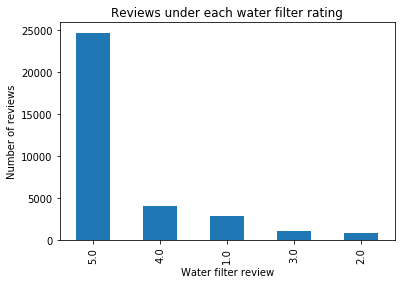

In [51]:
# plot to show reviews under each rating
df.overall.value_counts().plot.bar()
plt.title('Reviews under each water filter rating')
plt.xlabel('Water filter review')
plt.ylabel('Number of reviews')

***The data is imbalanced and the prediction mostly shows the neighbour classes as the words used in between neighbour classes are similar*** 

In [52]:
# finding unique rating
df.overall.unique()

array([5., 4., 1., 2., 3.])

In [53]:
# Rating 5 is taken as class 1, rating 2,3,4 is grouped under class 2 and rating 1 is the class 3
df.overall=df.overall.map({5.:1,4.:2,3.:2,.2:2,1.:3})


***The rating 2,3,4 are grouped together as 2 as the reviews are quite similar and difficult to interpret under the correct rating***

Text(0, 0.5, 'Number of reviews')

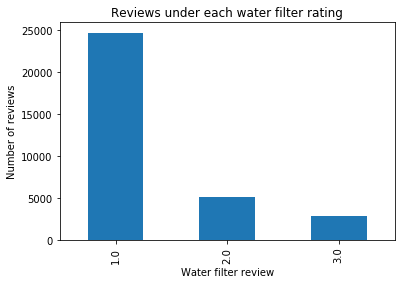

In [54]:
# Bar plot to show number of reviews after grouping the rating 2,3,4 together
df.overall.value_counts().plot.bar()
plt.title('Reviews under each water filter rating')
plt.xlabel('Water filter review')
plt.ylabel('Number of reviews')

***Even now the ratings are imbalanced but better than before***

In [55]:
# Number of reviews under each of the rating
df.overall.value_counts()

1.0    24690
2.0     5123
3.0     2823
Name: overall, dtype: int64

Text(0, 0.5, 'Number of reviews')

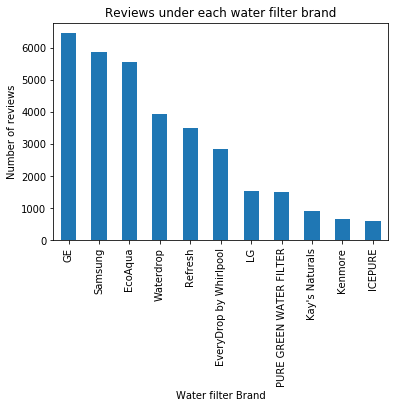

In [56]:
# Reviews under each filter brand
df.brand.value_counts().plot.bar()
plt.title('Reviews under each water filter brand')
plt.xlabel('Water filter Brand')
plt.ylabel('Number of reviews')

***The above plot shows that the top 3 popular filters include GE, Samsung and EcoAqua***

In [57]:
# Checking the unique title
df.title.unique()

array(['General Electric MWF Refrigerator Water Filter',
       'GE MSWF Refrigerator Water Filter, 1 Pack, White',
       'GE MWF3PK Smartwater Refrigerator Water Filter, 3 Pack',
       'LG LT700P Refrigerator Water Filter, Filters up to 300 Gallons of Water, Compatible with Select LG Multi-Door Refrigerators with SlimSpace Plus Ice System',
       'Samsung Genuine DA29-00020B Refrigerator Water Filter, 3 Pack',
       'Kenmore LG, 46-9690, LT700P, ADQ36006101, ADQ36006102, 048231783705, LT700 9690 Replacement Refrigerator Water Filter, White',
       'GE RPWFE Refrigerator Water Filter',
       'EcoAqua EFF-6007A Replacement for Maytag UKF8001, EDR4RXD1, Whirlpool 4396395, Puriclean II, Kenmore 46-9006, Everydrop filter 4, Viking RWFFR Refrigerator Water Filter, 3 Pack',
       'EcoAqua EFF-6013A Replacement for GE MWF SmartWater, MWFA, MWFP, GWF, GWFA, Kenmore 469991 Refrigerator Water Filter',
       'EcoAqua EFF-6027A Replacement for Samsung DA29-00020B, HAF-CIN/EXP, 46-9101 Refr

***Each brand have filters with different name based on the number of water filter in the package, their compatibility with fridges,physical and technical variations***

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33430 entries, 0 to 33429
Data columns (total 24 columns):
overall           32636 non-null float64
vote              1399 non-null object
reviewTime        33430 non-null object
reviewerID        33430 non-null object
asin              33430 non-null object
style             12143 non-null object
reviewerName      33430 non-null object
reviewText        33411 non-null object
summary           33423 non-null object
unixReviewTime    33430 non-null int64
year              33430 non-null int32
month             33430 non-null int32
category          33430 non-null object
description       28722 non-null object
title             33430 non-null object
brand             33430 non-null object
rank              33430 non-null object
main_cat          33430 non-null object
tech1             31294 non-null object
date              33430 non-null object
feature           28974 non-null object
title_year        33430 non-null object
title_month   

In [59]:
# dropping unnecessary columns
df = df.drop(columns=['vote','style','reviewerName','unixReviewTime','category', 'description','rank',
       'main_cat','date','title_month','title_year','feature','summary'])

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33430 entries, 0 to 33429
Data columns (total 11 columns):
overall        32636 non-null float64
reviewTime     33430 non-null object
reviewerID     33430 non-null object
asin           33430 non-null object
reviewText     33411 non-null object
year           33430 non-null int32
month          33430 non-null int32
title          33430 non-null object
brand          33430 non-null object
tech1          31294 non-null object
price_month    33430 non-null int64
dtypes: float64(1), int32(2), int64(1), object(7)
memory usage: 2.8+ MB


In [61]:
# drop null values
df = df.dropna()

In [62]:
# reindex columns according to our need
df = df.reindex(columns=['asin','title','tech1','reviewText','overall','reviewerID',
                        'reviewTime','year','month'])

In [63]:
df.head(1)

,asin,title,tech1,reviewText,overall,reviewerID,reviewTime,year,month
0,B000AST3AK,General Electric MWF Refrigerator Water Filter,"{'Part Number': 'MWF', 'Item Weight': '1 pound...",OEM GE water filter. Works great and as it sho...,1.0,A2ANMJ3F4N9WOV,"12 31, 2017",17,12


## CONVERTING WORDS INTO CORPUS

In [65]:
# describing our own stopwords to avoid some of the negative words like 'not' from being stopped
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
              "you'll","you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
              'she', "she's",'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
              'their', 'theirs','themselves',  'which', 'who', 'whom', 'this', 'that', "that'll", 'these',
              'those', 'am', 'is','are', 'was', 'were', 'be', 'been', 'being',  'a', 'an', 'the', 'and',
              'or', 'as','for','of', 'all','would','at', 'by', 'through', 'to', 'from', 'in', 'out','on',
              'off',  'then', 'here','there', 'when', 'one','where', 'why', 'how','so',   's', 't',
              'd', 'll', 'm', 'o','re', 've','y', 'ain','if','ma','what', 'aa','will','name','have',
              'with','go']

In [66]:
# function to do initial cleaning by setting regex to alphanumeric, changing to lower case and to remove stop words
def clean_round1(text):
# [A-Za-z]+ this regex finds the words 
# The result of text is a list    
    text = re.findall('[A-Za-z]+',text)
# convert all the text collected from regex into lower case in a list using list comprehension
    text = [x.lower() for x in text]
# write all words other than stop words into a list
    text = [w for w in text if not w in stop_words]
# converting list into string    
    text = ' '.join(text)
    return text

In [67]:
# Applying the cleaning function to the reviewText
df['cleanText']=df['reviewText'].apply(lambda x: clean_round1(x))

In [68]:
# lemmatized text using spacy. stemming is not done as some cell will only have null values after stemming
nlp =spacy.load('en_core_web_sm')
df['lemmatext']=df['cleanText'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

In [69]:
# stemming is done to clean the data and reduce features, which will reduce the complexity of the model
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
df['stemtext'] = [ps.stem(x) for x in df['lemmatext']]


In [70]:
# encoding using TFIDF vectorizer. Bigrams and Trigrams are created to feed meaningful features to the model
tfid = TfidfVectorizer(stop_words=stop_words,max_features=6000,ngram_range=(1, 3))

# Fit our vectorizer on the lemmatized data
tfid.fit(df['stemtext'])

# and check out the length of the vectorized data after
len(tfid.get_feature_names())

6000

In [71]:
# encoding using count vectorizer. Bigrams and Trigrams are created to feed meaningful features to the model
cvec = CountVectorizer(stop_words=stop_words,max_features=6000,ngram_range=(1, 3))

# Fit our vectorizer on the lemmatized data
cvec.fit(df['stemtext'])

# and check out the length of the vectorized data after
len(cvec.get_feature_names())

6000

In [72]:
# index is changed after vectorization. so index before vectorisation is saved as a list 
# and to used in the dataframe after vectorization.
index = []
for row in df['stemtext'].index: 
    index.append(row)

In [73]:
# Dataframe created with vectorized stemtext column using TFIDF vectorizer.
X_tfid = pd.DataFrame(tfid.transform(df['stemtext']).todense(),columns=tfid.get_feature_names(),index=index)
X_tfid.head()

,ability,able,able buy,able find,able get,about,about buy,about cheap,about day,about every,...,year use,year work,yep,yes,yesterday,yet,yet but,youtube,zero,zero water
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.136164,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
# Dataframe created with vectorized stemtext column using count vectorizer.
X_cvec = pd.DataFrame(cvec.transform(df['stemtext']).todense(),
                       columns=cvec.get_feature_names(),index=index)
X_cvec.head()

,ability,able,able buy,able find,able get,about,about buy,about cheap,about day,about every,...,year use,year work,yep,yes,yesterday,yet,yet but,youtube,zero,zero water
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# EXPLORATORY DATA ANALYSIS

In [76]:
# top 100 words used in ratings
word_counts = X_tfid.sum(axis=0)
print(len(word_counts))
word_counts.sort_values(ascending = False).head(100)

6000


great            1575.480568
work             1429.699146
filter           1109.900695
good             1080.176821
water             871.793148
product           756.239631
work great        725.499701
fit               719.295507
perfect           666.682440
price             585.124018
just              471.458036
taste             463.012044
easy              456.447844
pric              451.918138
buy               450.034383
do                443.814194
no                440.894251
not               428.695011
but               411.185121
very              408.735264
well              385.641411
expect            378.568567
than              358.111788
samsung           348.230294
great product     317.714638
brand             317.706686
instal            314.899960
refrigerator      313.271643
filt              310.267883
like              307.552308
                    ...     
more              196.390818
perfectli         195.661045
expensive         192.641165
far           

In [77]:
# As class 1, 2, 3 is not clear enough we give them a name good, average, bad respectively
target_name=['good','average','bad']


In [78]:
# Top words used in each of the class is saved under different list
common_words_good = []
common_words_average = []
common_words_bad = []


for i in range(1,4):
    word_count = X_tfid[df.overall==i].sum(axis=0)
    print ("filter",target_name[i-1], "most common words")
    if i == 1:
        cw_good = word_count.sort_values(ascending = False).head(50)
        common_words_good.extend(cw_good.index)
        print(cw_good[0:50])
    elif i == 2:
        cw_average = word_count.sort_values(ascending = False).head(50)
        common_words_average.extend(cw_average.index)
        print(cw_average[0:50])
    elif i == 3:
        cw_bad = word_count.sort_values(ascending = False).head(50)
        common_words_bad.extend(cw_bad.index)
        print(cw_bad[0:50])
 

filter good most common words
great            1456.124196
work             1150.213048
good              839.698493
filter            722.482145
work great        672.657869
perfect           632.710550
product           618.535182
fit               592.536709
water             549.061271
price             493.192471
pric              390.751389
easy              389.902989
just              366.008593
no                339.424435
very              328.083695
buy               322.720985
taste             314.432587
expect            309.910221
great product     298.996821
well              294.850399
than              274.683243
thank             248.916002
samsung           248.091154
brand             243.712032
exactly           243.047634
do                241.295830
replacement       237.354877
again             236.614095
filt              235.826987
perfectly         233.374068
instal            224.996129
refrigerator      223.763793
fast              221.666954
ge           

In [79]:
# dataframe built for the top words in individual classes
wf_topwords = pd.DataFrame(common_words_good,columns=['common_words_good'])
wf_topwords['common_words_average']=common_words_average
wf_topwords['common_words_bad']=common_words_bad


In [80]:
# Reindex the columns
wf_topwords_columns=['common_words_good','common_words_average','common_words_bad']

In [81]:
# Wordplot constructed to visualize the top words used under different classes
def word_plot(columns,dataframe,titles):
    fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,30))
    axes = axes.ravel()
    for i,item in enumerate (columns):
        axes[i].imshow(WordCloud(width=4000,height=4000,colormap="Dark2").generate(str(dataframe[item])))
        axes[i].set_title(titles[i],fontsize = 20)
        axes[i].axis('off')
    plt.savefig('../word_plot')

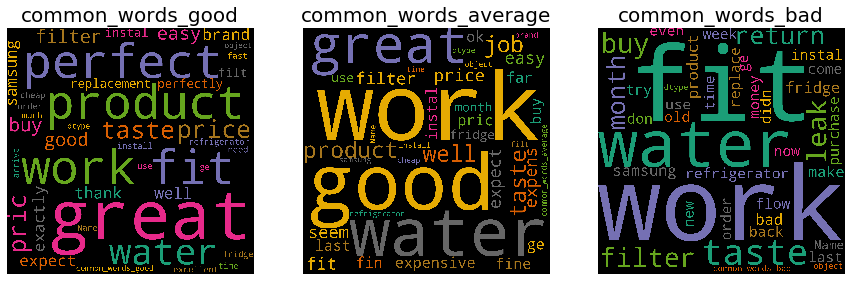

In [82]:
word_plot(wf_topwords_columns,wf_topwords,wf_topwords_columns)

- Good reviews have more positive words like great, perfect, work, fit etc
- Average reviews have top words like good and also great, work, expensive
- bad reviews have words like leak, bad, didn, return apart from fit work

# MODELLING

## TEXT CLASSIFICATION

In [83]:
# Function to create models
def classifier(classifier,X,y,target_name=['good','average','bad'],downsample=False,upsample = False, kfold=False,pca=False,pca_features=1500):
        
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True,random_state=1)
    if downsample == True:
        nm = NearMiss()
        X_train, y_train = nm.fit_sample(X_train, y_train) 
    elif upsample == True:
        smt = SMOTE()
        X_train, y_train = smt.fit_sample(X_train,y_train)
    elif pca == True:
        pca_model = PCA(pca_features)
        pca_model.fit(X_train)
        X_train = pca_model.transform(X_train)
        X_test = pca_model.transform(X_test)
        
        
    model = classifier.fit(X_train, y_train)
    print(classifier)
    print('*'*100)
    print('training score',classifier.score(X_train,y_train))
    y_pred=model.predict(X_test)
    print('test score',classifier.score(X_test,y_test))
    cm=confusion_matrix(y_test, y_pred)
    print('*'*100)
    print('Classification Report')
    print(classification_report(y_test, y_pred,target_names=target_name))
    print('*'*100)
    print('Confusion Matrix')
    print(cm)
    return y_test, y_pred

### BASELINE MODEL WITH LOGISTICS REGRESSION 

In [84]:
y_test, y_pred = classifier(LogisticRegression(solver ='liblinear'),X_tfid, df['overall'])

C:\Users\abinl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
****************************************************************************************************
training score 0.8560788967549208
test score 0.839607201309329
****************************************************************************************************
Classification Report
              precision    recall  f1-score   support

        good       0.85      0.97      0.91      4722
     average       0.63      0.21      0.31       894
         bad       0.82      0.69      0.75       494

    accuracy                           0.84      6110
   macro avg       0.77      0.62      0.66      6110
weighted avg       0.82      0.84      0.81      6110

**

***Baseline model TFIDF with Logistics regression is good for majority class.***

In [85]:
y_test, y_pred_cvec = classifier(LogisticRegression(solver ='liblinear'),X_cvec, df['overall'])

C:\Users\abinl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
****************************************************************************************************
training score 0.9010107623685395
test score 0.8443535188216039
****************************************************************************************************
Classification Report
              precision    recall  f1-score   support

        good       0.87      0.96      0.91      4722
     average       0.56      0.30      0.39       894
         bad       0.83      0.76      0.79       494

    accuracy                           0.84      6110
   macro avg       0.76      0.67      0.70      6110
weighted avg       0.82      0.84      0.83      6110

*

***Logistics Regression with count vectorizer is better than Count vectorizer output with a f1 score of 0.83***

In [86]:
y_test, y_pred_ds = classifier(LogisticRegression(solver ='liblinear'),X_cvec, df['overall'],downsample=True)

C:\Users\abinl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
****************************************************************************************************
training score 0.897423352902805
test score 0.339607201309329
****************************************************************************************************
Classification Report
              precision    recall  f1-score   support

        good       0.90      0.22      0.35      4722
     average       0.16      0.66      0.26       894
         bad       0.35      0.93      0.51       494

    accuracy                           0.34      6110
   macro avg       0.47      0.60      0.37      6110
weighted avg       0.75      0.34      0.35      6110

***

***Downsample classified most of the rating as the majority class. The recall of the model is very poor***

In [87]:
#y_test, y_pred_us = classifier(LogisticRegression(solver ='liblinear'),X_cvec, df['overall'],upsample=True)

***System could not handle upsample. But it doesn't perform well also with small dataset.***

In [88]:
y_test, y_pred_pca = classifier(LogisticRegression(solver ='liblinear'),X_cvec, df['overall'],pca=True)

C:\Users\abinl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
****************************************************************************************************
training score 0.8658182264598764
test score 0.8378068739770868
****************************************************************************************************
Classification Report
              precision    recall  f1-score   support

        good       0.86      0.96      0.91      4722
     average       0.54      0.24      0.34       894
         bad       0.81      0.72      0.76       494

    accuracy                           0.84      6110
   macro avg       0.74      0.64      0.67      6110
weighted avg       0.81      0.84      0.81      6110

*

***PCA is quite similar to baseline model. But not bad.***

### MULTINOMIAL NAIVE BAYES

In [89]:
y_test, y_pred_mnb_tfid = classifier(MultinomialNB(),X_tfid, df['overall'])



MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
****************************************************************************************************
training score 0.8427384703523346
test score 0.839607201309329
****************************************************************************************************
Classification Report
              precision    recall  f1-score   support

        good       0.86      0.97      0.91      4722
     average       0.57      0.20      0.30       894
         bad       0.78      0.78      0.78       494

    accuracy                           0.84      6110
   macro avg       0.74      0.65      0.66      6110
weighted avg       0.81      0.84      0.81      6110

****************************************************************************************************
Confusion Matrix
[[4564  109   49]
 [ 653  180   61]
 [  82   26  386]]


***Recall is lesser for class average, but good for class good***

In [90]:
y_test, y_pred_mnb_cvec=classifier(MultinomialNB(),X_cvec, df['overall'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
****************************************************************************************************
training score 0.8205180668658182
test score 0.8137479541734861
****************************************************************************************************
Classification Report
              precision    recall  f1-score   support

        good       0.90      0.89      0.89      4722
     average       0.44      0.38      0.41       894
         bad       0.68      0.88      0.76       494

    accuracy                           0.81      6110
   macro avg       0.67      0.72      0.69      6110
weighted avg       0.81      0.81      0.81      6110

****************************************************************************************************
Confusion Matrix
[[4198  406  118]
 [ 464  341   89]
 [  25   36  433]]


***In this one recall is better than previous model for average class but precision is reduced***

### SVM

In [91]:
y_test, y_pred_svc=classifier(LinearSVC(C=1),X_tfid, df['overall'])

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
****************************************************************************************************
training score 0.8996194295535459
test score 0.8410801963993453
****************************************************************************************************
Classification Report
              precision    recall  f1-score   support

        good       0.87      0.95      0.91      4722
     average       0.53      0.30      0.38       894
         bad       0.82      0.76      0.79       494

    accuracy                           0.84      6110
   macro avg       0.74      0.67      0.69      6110
weighted avg       0.82      0.84      0.82      6110

****************************************************************************************************
Co

***SVM is not bad but the F1-score is lesser than logreg+cvec***

In [95]:
y_test, y_pred_svc_cvec=classifier(LinearSVC(loss='l2'),X_cvec, df['overall'])

C:\Users\abinl\Anaconda3\lib\site-packages\sklearn\svm\classes.py:220: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)
C:\Users\abinl\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
****************************************************************************************************
training score 0.9290011048819413
test score 0.8227495908346972
****************************************************************************************************
Classification Report
              precision    recall  f1-score   support

        good       0.88      0.92      0.90      4722
     average       0.45      0.35      0.39       894
         bad       0.80      0.75      0.77       494

    accuracy                           0.82      6110
   macro avg       0.71      0.67      0.69      6110
weighted avg       0.81      0.82      0.81      6110

****************************************************************************************************


***This model overfit with the train data but not bad F1 score vise.***

In [97]:
y_test, y_pred_svc_pca=classifier(LinearSVC(loss='l2'),X_tfid, df['overall'],pca=True)

C:\Users\abinl\Anaconda3\lib\site-packages\sklearn\svm\classes.py:220: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
****************************************************************************************************
training score 0.8572656218030037
test score 0.8412438625204582
****************************************************************************************************
Classification Report
              precision    recall  f1-score   support

        good       0.86      0.97      0.91      4722
     average       0.55      0.23      0.32       894
         bad       0.83      0.76      0.79       494

    accuracy                           0.84      6110
   macro avg       0.75      0.65      0.68      6110
weighted avg       0.81      0.84      0.82      6110

****************************************************************************************************


***PCA doesn't affect the F1 score***

### TREE CLASSIFIERS

In [99]:
y_test, y_pred_abc=classifier(AdaBoostClassifier(learning_rate=0.8,random_state=1),X_cvec, df['overall'])


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.8,
                   n_estimators=50, random_state=1)
****************************************************************************************************
training score 0.7981339771657732
test score 0.8142389525368249
****************************************************************************************************
Classification Report
              precision    recall  f1-score   support

        good       0.83      0.98      0.90      4722
     average       0.58      0.11      0.18       894
         bad       0.73      0.54      0.62       494

    accuracy                           0.81      6110
   macro avg       0.71      0.54      0.56      6110
weighted avg       0.78      0.81      0.77      6110

****************************************************************************************************
Confusion Matrix
[[4614   52   56]
 [ 757   94   43]
 [ 212   15  267]]


***F1 score is lesser and also recall for average class is only 11%***

In [100]:
y_test, y_pred_abc_cvec=classifier(AdaBoostClassifier(random_state=1),X_cvec, df['overall'])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)
****************************************************************************************************
training score 0.7985431926995948
test score 0.8142389525368249
****************************************************************************************************
Classification Report
              precision    recall  f1-score   support

        good       0.83      0.97      0.90      4722
     average       0.54      0.11      0.18       894
         bad       0.70      0.59      0.64       494

    accuracy                           0.81      6110
   macro avg       0.69      0.55      0.57      6110
weighted avg       0.78      0.81      0.77      6110

****************************************************************************************************
Confusion Matrix
[[4591   65   66]
 [ 743   95   56]
 [ 188   17  289]]


***Adaboost performance doesn't change with vectorizer***

In [101]:
y_test, y_pred_rfc=classifier(RandomForestClassifier(n_estimators=300,random_state=24,n_jobs=-1),X_cvec, df['overall'])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=24, verbose=0,
                       warm_start=False)
****************************************************************************************************
training score 0.971968735933216
test score 0.839443535188216
****************************************************************************************************
Classification Report
              precision    recall  f1-score   support

        good       0.85      0.97      0.91      4722
     average       0.64      0.20      0.31       894
         bad       0.81      0.70      0.75       494

    accur

***Good.But,F1 score is lower by 2% than logreg + cvec***

In [102]:
y_test, y_pred_etc=classifier(ExtraTreesClassifier(bootstrap=True,n_estimators=100,n_jobs = -1),X_cvec, df['overall'])


ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
****************************************************************************************************
training score 0.971968735933216
test score 0.8425531914893617
****************************************************************************************************
Classification Report
              precision    recall  f1-score   support

        good       0.85      0.97      0.91      4722
     average       0.68      0.21      0.33       894
         bad       0.81      0.72      0.76       494

    accuracy        

***This model similar to random forest***

### VOTING CLASSIFIER WITH ENSEMBLE TECHNIQUE

In [103]:
clf1 = LogisticRegression(solver = 'lbfgs',random_state=26)
clf2 = ExtraTreesClassifier(n_estimators=100,random_state=23,n_jobs=-1)
clf3 = RandomForestClassifier(n_estimators=300,random_state=24,n_jobs=-1)
labels = ['Logistic Regression', 'extratree', 'Random Forest']
vc = VotingClassifier(estimators = [(labels[0], clf1),(labels[1], clf2),(labels[2], clf3)],voting = 'hard')


In [104]:
y_test, y_pred_vc=classifier(vc,X_cvec, df['overall'])

C:\Users\abinl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\abinl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\abinl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\abinl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=26,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('extratree',
                              ExtraTreesClassifier(bootstrap=False,
                                                   class_weight=N...
                                                     class_weight=None,
                       

***Take more time to run but f1 score 1% lesses than logreg + cvec***

### FINAL MODEL (Logistics Regression using Count Vectorizer)

In [105]:
y_test, y_pred_cvec = classifier(LogisticRegression(solver ='liblinear'),X_cvec, df['overall'])

C:\Users\abinl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
****************************************************************************************************
training score 0.9010107623685395
test score 0.8443535188216039
****************************************************************************************************
Classification Report
              precision    recall  f1-score   support

        good       0.87      0.96      0.91      4722
     average       0.56      0.30      0.39       894
         bad       0.83      0.76      0.79       494

    accuracy                           0.84      6110
   macro avg       0.76      0.67      0.70      6110
weighted avg       0.82      0.84      0.83      6110

*

***This model have better accuracy than other model. But, still the recall for overage class is only 30%, also precision is only 56%. But good, the average F1 score is 83%***

In [106]:
# obtaining index of y-test
indices = []
for row in y_test.index: 
    indices.append(row)

In [107]:
# combining y-text with stemtext based on the index
df1 = df.loc[:,['reviewText','stemtext']]
df_pred = pd.DataFrame(y_pred_cvec, columns=['predicted rating'],index=indices)
df2 = y_test.to_frame()
df_temp = df2.join(df_pred)
df_check = pd.concat([df1, df_temp], axis=1, join='inner')

In [108]:
# Check where y-test not equal to prediction.
pd.set_option('display.max_colwidth', 50)
df_check[df_check['overall'] != df_check['predicted rating']]

,reviewText,stemtext,overall,predicted rating
24,Stick with OEM product. Slowly pours water and...,stick oem product slowly pour water constantly...,3.0,1.0
34,"not much to say, easy to install and no leaks",not much say easy install no leak,2.0,1.0
36,Seems to be working just fine. It's OEM so I'm...,seem work just fine oem sure do job,1.0,2.0
73,The water filter on my fridge died and instead...,water filter fridge die instead pay arm leg bu...,1.0,2.0
134,Made my water taste fresh again! I bought a ge...,make water taste fresh again buy generic brand...,2.0,1.0
193,"Seems to work, as water stays fresh and clear ...",seem work water stay fresh clear without unusu...,1.0,2.0
197,Water still tastes bad... brita filters are wa...,water still taste bad brita filter way well re...,2.0,1.0
202,Had a cheap generic filter which severely limi...,have cheap generic filter severely limited wat...,1.0,2.0
235,"Great, but expensive filter. It gets the job d...",great but expensive filter get job do make sur...,1.0,2.0
294,"I could have purchased the cheaper ones, howev...",could purchase cheap one however ge protect wi...,1.0,2.0


***Most of the Class 2 is identified as Class 1 and Viceversa.

In [109]:
## Check where y-test is equal to prediction.
df_check[df_check['overall'] == df_check['predicted rating']]

,reviewText,stemtext,overall,predicted rating
2,"We tried two or three different clones, they c...",try two three different clone clog within mont...,2.0,2.0
11,Very Good,very good,1.0,1.0
22,"I was leery about buying a knock off, all the ...",leery about buy knock knock off look didn prov...,1.0,1.0
23,Just as described,just describ,1.0,1.0
32,Original factory filter at a great price. They...,original factory filter great price run each,1.0,1.0
33,Worked fine. Price is less than oem,work fine price less than oem,1.0,1.0
37,Just what we needed,just ne,1.0,1.0
40,"Arrived quickly, installed easily and made wat...",arrive quickly instal easily make water taste ...,1.0,1.0
44,Great,great,1.0,1.0
45,Works as intended. Cheaper than buying direct...,work intend cheap than buy directly g,1.0,1.0


In [110]:
# Calculating the confusion matrix
cm_cvec=confusion_matrix(y_test, y_pred_cvec)

Text(0.5, 1, 'Confusion matrix for final model')

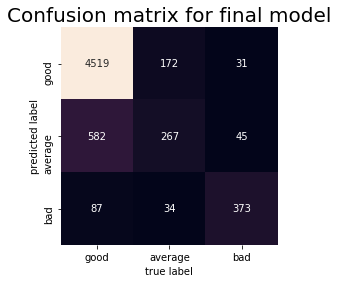

In [118]:
# Visualizing Confusion matrix
g = sns.heatmap(cm_cvec,annot=True,square=True,cbar=False,fmt="d")
g.set_xticklabels(target_name)
g.set_yticklabels(target_name)
g.set_xlabel("true label",fontsize = 10)
g.set_ylabel("predicted label",fontsize = 10)
g.set_title("Confusion matrix for final model",size = 20)

- Class good have True positive = 4519 out off 5188 with a False positive of 203 and False negative of 669
- Class average have True positive = 267 out off 473 with a False positive of 894 and False negative of 206
- Class bad have True positive = 373 out off 449 with a False positive of 121 and False negative of 76



|Class|Actual|True Positive|False Positive|True Negative|False Negative|
|---|---|---|---|---|---|
|Good|5188|4519|203|640|669|
|Average|473|267|894|4892|206|
|Bad|449|373|121|4786|76|


***Conclusion for Text Classification:***
- We can realize from the above table that eventhough Class Bad is the minor class it still perform well because most of the vocabulary are unique to the class, While Class Average have vocabulary similar to class good. That's why the model only have a average F1 score of 83%. 
- Also some times the rating for the reviews are not well defined. 
- words in the reviews are not clear enough to classify the rating.
- For the product development department, In design point of view from the top words we can see customers are expecting a filter without leak, good water taste, inexpensive and to work well.